In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from torch.utils.data import Dataset, DataLoader, Subset
import torch
import torch.nn as nn
from transformers import AutoModel
import os
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, silhouette_score, davies_bouldin_score, silhouette_samples
from sklearn.preprocessing import LabelEncoder



c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Cleaned_Tickets.csv")
print(df.shape)
print(df.columns)
df.head()

(16337, 14)
Index(['subject', 'body', 'answer', 'type', 'department', 'priority', 'tag_1',
       'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8'],
      dtype='object')


,subject,body,answer,type,department,priority,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Account Disruption,"Dear Customer Support Team, I am writing to re...",Thank you for reaching out. We are aware of th...,Incident,Technical Support,High,Account,Disruption,Outage,Disruption,Outage,IT,Tech Support,NaN
1,Query About Smart Home System Integration Feat...,"Dear Customer Support Team, I hope this messag...",Thank you for your inquiry. Our products suppo...,Request,Returns And Exchanges,Medium,Product,Feature,Tech Support,Feature,Tech Support,NaN,NaN,NaN
2,Inquiry Regarding Invoice Details,"Dear Customer Support Team, I hope this messag...",We appreciate you reaching out with your billi...,Request,Billing And Payments,Low,Billing,Payment,Account,Payment,Account,Documentation,Feedback,NaN
3,Question About Marketing Agency Software Compa...,"Dear Support Team, I hope this message reaches...",Thank you for your inquiry. Our product suppor...,Problem,Sales And Pre-Sales,Medium,Product,Feature,Feedback,Feature,Feedback,Tech Support,NaN,NaN
4,Feature Query,"Dear Customer Support, I hope this message rea...",Thank you for your inquiry. Please specify whi...,Request,Technical Support,High,Feature,Product,Documentation,Product,Documentation,Feedback,NaN,NaN


In [3]:
print(df.isnull().sum())

subject           0
body              0
answer            3
type              0
department        0
priority          0
tag_1             0
tag_2             0
tag_3             0
tag_4          2556
tag_5          2603
tag_6          3988
tag_7          9317
tag_8         13637
dtype: int64


In [4]:
tag_columns  = ["tag_1", "tag_2", "tag_3"]
df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")

In [5]:
# Flatten all tag columns into one list
all_tags = df[tag_columns].values.flatten()
all_tags = [tag for tag in all_tags if pd.notnull(tag)]
unique_tags = sorted(set(all_tags))

tag_counter = Counter(all_tags)


In [6]:
tag_freq_df = pd.DataFrame.from_dict(tag_counter, orient="index", columns=["count"])
tag_freq_df = tag_freq_df.sort_values("count", ascending=False)
tag_freq_df.reset_index(inplace=True)
tag_freq_df.columns = ["tag", "count"]

tag_freq_df.head(10)

,tag,count
0,Performance,6607
1,IT,5153
2,Feedback,3903
3,Security,3677
4,Bug,3649
5,Feature,3162
6,Disruption,2430
7,Documentation,2342
8,Outage,2222
9,Network,2003


In [7]:
print(f"Total unique tags: {len(tag_freq_df)}")
print(f"Tags appearing only once: {(tag_freq_df['count'] == 1).sum()}")
print(f"Tags appearing <= 5 times: {(tag_freq_df['count'] <= 5).sum()}")
print(f"Tags appearing >= 100 times: {(tag_freq_df['count'] >= 100).sum()}")

Total unique tags: 367
Tags appearing only once: 139
Tags appearing <= 5 times: 242
Tags appearing >= 100 times: 37


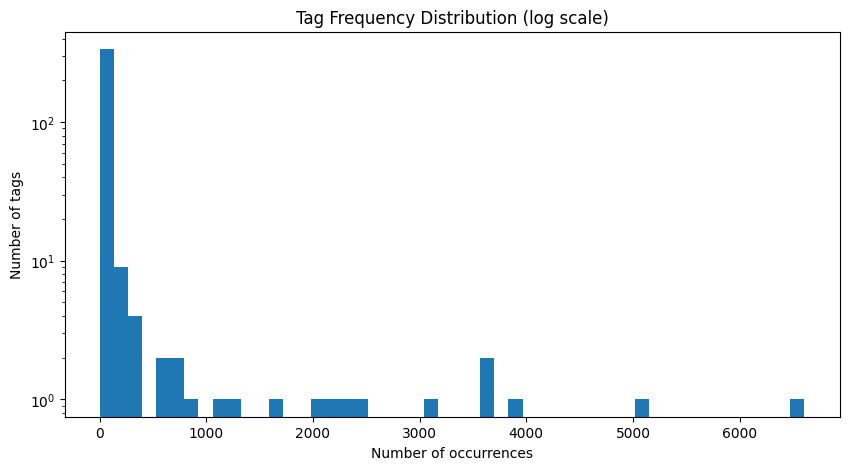

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(tag_freq_df["count"], bins=50, log=True)
plt.title("Tag Frequency Distribution (log scale)")
plt.xlabel("Number of occurrences")
plt.ylabel("Number of tags")
plt.show()

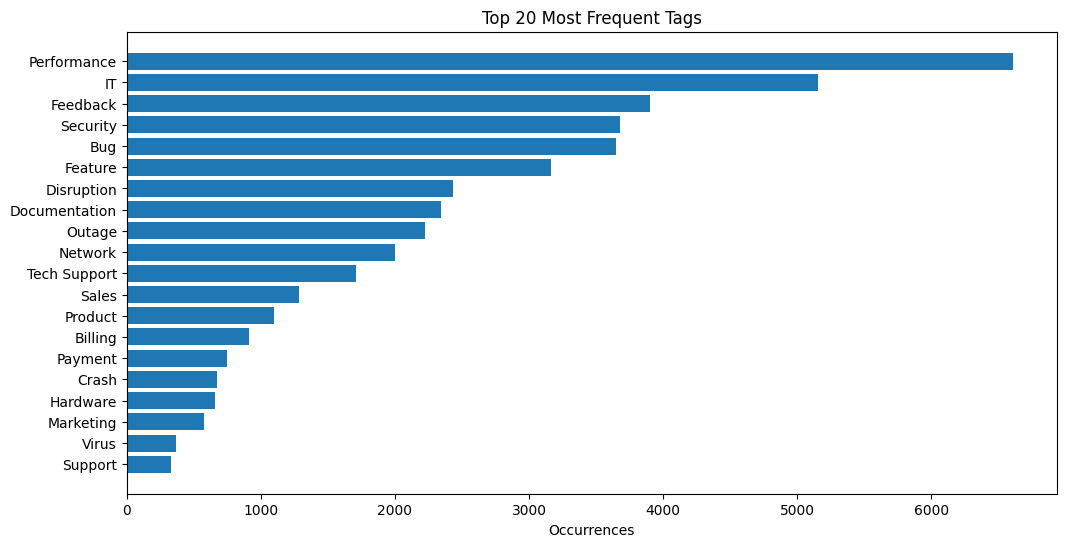

In [9]:
top_n = 20

plt.figure(figsize=(12, 6))
plt.barh(tag_freq_df["tag"][:top_n][::-1], tag_freq_df["count"][:top_n][::-1])
plt.title(f"Top {top_n} Most Frequent Tags")
plt.xlabel("Occurrences")
plt.show()

In [10]:
# Embed tags using sentence-transformers
model = SentenceTransformer("all-MiniLM-L6-v2")

tag_embeddings = model.encode(unique_tags, show_progress_bar=True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 12/12 [00:00<00:00, 47.02it/s]


In [11]:
# Cluster tags with KMeans
n_clusters = 15
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(tag_embeddings)

In [12]:
# Create tag_to_cluster mapping
tag_to_cluster = {tag: f"Cluster_{cid}" for tag, cid in zip(unique_tags, cluster_ids)}

# Reverse mapping
cluster_to_tags = defaultdict(list)
for tag, cluster in tag_to_cluster.items():
    cluster_to_tags[cluster].append(tag)


In [117]:
# Create cluster ID mappings
cluster_list = sorted(cluster_to_tags.keys())
cluster2id = {cluster: i for i, cluster in enumerate(cluster_list)}
id2cluster = {i: cluster for cluster, i in cluster2id.items()}

# Create tag ID mappings (filtered to tags in tag_to_cluster only)
tag_list = sorted(tag_to_cluster.keys())
tag2id = {tag: i for i, tag in enumerate(tag_list)}
id2tag = {i: tag for tag, i in tag2id.items()}

global_tag2id = tag2id.copy()
global_id2tag = id2tag.copy()

In [14]:
def encode_clusters(row):
    tags = [row[col] for col in tag_columns if pd.notnull(row[col])]
    clusters = set(tag_to_cluster[t] for t in tags if t in tag_to_cluster)
    vec = np.zeros(len(cluster2id), dtype=np.float32)
    for c in clusters:
        vec[cluster2id[c]] = 1.0
    return vec

def encode_tags(row):
    tags = [row[col] for col in tag_columns if pd.notnull(row[col])]
    vec = np.zeros(len(tag2id), dtype=np.float32)
    for t in tags:
        if t in tag2id:
            vec[tag2id[t]] = 1.0
    return vec

In [15]:
df["cluster_vector"] = df.apply(encode_clusters, axis=1)
df["tag_vector"] = df.apply(encode_tags, axis=1)

Silhouette Score (overall): 0.0591
Davies–Bouldin Index: 3.0944
    Cluster ID  Size  Mean Silhouette
4            4    46         0.001731
12          12    51         0.001940
7            7    49         0.003358
6            6    37         0.019771
0            0    26         0.044749
8            8    20         0.058097
3            3    18         0.075430
5            5    15         0.079574
10          10    19         0.094758
9            9    19         0.095636


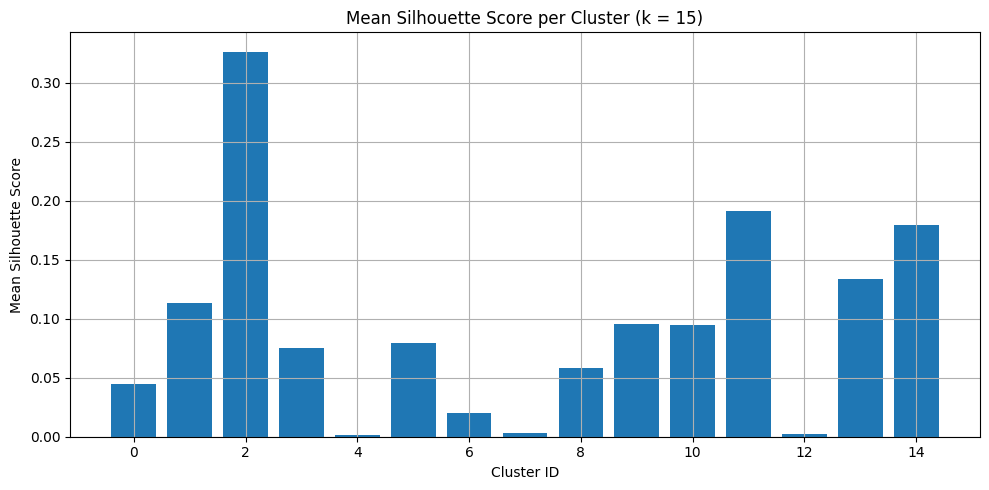

In [16]:
# Clustering Metrics
cluster_ids_str = [tag_to_cluster[tag] for tag in unique_tags]

X = np.vstack(tag_embeddings)
y = LabelEncoder().fit_transform(cluster_ids_str)

sil_score = silhouette_score(X, y)
db_index = davies_bouldin_score(X, y)

print(f"Silhouette Score (overall): {sil_score:.4f}")
print(f"Davies–Bouldin Index: {db_index:.4f}")

# Per-cluster silhouette scores
silhouette_vals = silhouette_samples(X, y)

cluster_metrics = []
for cluster_id in np.unique(y):
    mask = y == cluster_id
    size = np.sum(mask)
    mean_sil = silhouette_vals[mask].mean()
    cluster_metrics.append({
        "Cluster ID": cluster_id,
        "Size": size,
        "Mean Silhouette": mean_sil
    })

cluster_metrics_df = pd.DataFrame(cluster_metrics).sort_values(by="Mean Silhouette")
print(cluster_metrics_df.head(10))

# Mean silhouette per cluster plot
plt.figure(figsize=(10, 5))
plt.bar(cluster_metrics_df["Cluster ID"], cluster_metrics_df["Mean Silhouette"])
plt.xlabel("Cluster ID")
plt.ylabel("Mean Silhouette Score")
plt.title(f"Mean Silhouette Score per Cluster (k = {n_clusters})")
plt.grid(True)
plt.tight_layout()
plt.show()

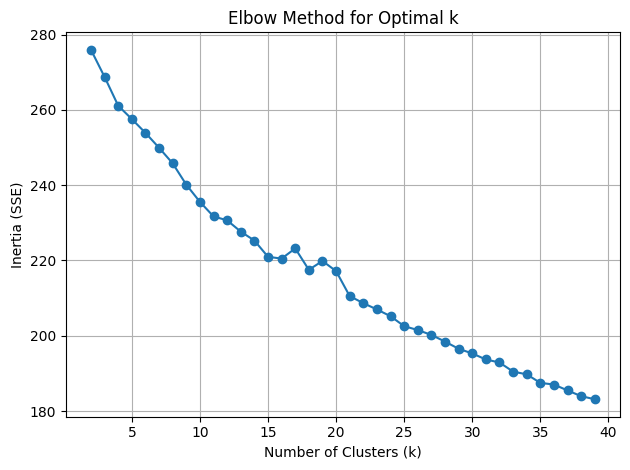

In [17]:
# Elbow method
sse = []
K = range(2, 40)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(K, sse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Training-Validation-Test split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 13069, Val: 1634, Test: 1634


In [19]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_texts(text_list):
    return tokenizer(
        text_list,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

In [20]:
train_enc = tokenize_texts(train_df["text"].tolist())
val_enc   = tokenize_texts(val_df["text"].tolist())
test_enc  = tokenize_texts(test_df["text"].tolist())

In [21]:
class ClusterDataset(Dataset):
    def __init__(self, encodings, cluster_vectors):
        self.encodings = encodings
        self.cluster_vectors = cluster_vectors

    def __len__(self):
        return len(self.cluster_vectors)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.cluster_vectors[idx], dtype=torch.float32)
        }

In [22]:
class TagDataset(Dataset):
    def __init__(self, encodings, tag_vectors):
        self.encodings = encodings
        self.tag_vectors = tag_vectors

    def __len__(self):
        return len(self.tag_vectors)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.tag_vectors[idx], dtype=torch.float32)
        }

In [23]:
train_cluster_ds = ClusterDataset(train_enc, train_df["cluster_vector"].tolist())
val_cluster_ds   = ClusterDataset(val_enc,   val_df["cluster_vector"].tolist())
test_cluster_ds  = ClusterDataset(test_enc,  test_df["cluster_vector"].tolist())

In [24]:
train_cluster_loader = DataLoader(train_cluster_ds, batch_size=16, shuffle=True)
val_cluster_loader   = DataLoader(val_cluster_ds, batch_size=16)
test_cluster_loader  = DataLoader(test_cluster_ds, batch_size=16)

In [25]:
class ClusterClassifier(nn.Module):
    def __init__(self, num_clusters):
        super().__init__()
        self.bert = AutoModel.from_pretrained("bert-base-cased")
        self.dropout1 = nn.Dropout(0.3)
        self.hidden = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.classifier = nn.Linear(256, num_clusters)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # shape: [batch_size, 768]
        
        x = self.dropout1(pooled_output)
        x = self.hidden(x)         # shape: [batch_size, 256]
        x = self.relu(x)
        x = self.dropout2(x)
        logits = self.classifier(x)  # shape: [batch_size, num_clusters]
        return logits

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [27]:
def train_stage1_with_early_stopping(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    num_epochs=10,
    patience=3,
    save_path="best_stage1.pt"
):
    model.to(device)
    best_val_loss = float("inf")
    epochs_no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch} - Training"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Store loss per epoch
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            print("New best model! Saving...")
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    print(f"Training complete. Best val loss: {best_val_loss:.4f}")
    return history



In [28]:
model = ClusterClassifier(num_clusters=len(cluster2id))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.BCEWithLogitsLoss()

history = train_stage1_with_early_stopping(
    model=model,
    train_loader=train_cluster_loader,
    val_loader=val_cluster_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    num_epochs=10,
    patience=3,
    save_path="best_stage1.pt"
)

Epoch 1 - Training:   0%|          | 0/817 [00:00<?, ?it/s]c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1 - Training: 100%|██████████| 817/817 [01:00<00:00, 13.59it/s]


Epoch 1 - Train Loss: 0.2383 - Val Loss: 0.1548
New best model! Saving...


Epoch 2 - Training: 100%|██████████| 817/817 [00:59<00:00, 13.66it/s]


Epoch 2 - Train Loss: 0.1513 - Val Loss: 0.1348
New best model! Saving...


Epoch 3 - Training: 100%|██████████| 817/817 [00:59<00:00, 13.68it/s]


Epoch 3 - Train Loss: 0.1305 - Val Loss: 0.1237
New best model! Saving...


Epoch 4 - Training: 100%|██████████| 817/817 [00:59<00:00, 13.68it/s]


Epoch 4 - Train Loss: 0.1119 - Val Loss: 0.1218
New best model! Saving...


Epoch 5 - Training: 100%|██████████| 817/817 [01:00<00:00, 13.59it/s]


Epoch 5 - Train Loss: 0.0969 - Val Loss: 0.1205
New best model! Saving...


Epoch 6 - Training: 100%|██████████| 817/817 [01:01<00:00, 13.32it/s]


Epoch 6 - Train Loss: 0.0821 - Val Loss: 0.1250
No improvement for 1 epoch(s).


Epoch 7 - Training: 100%|██████████| 817/817 [01:00<00:00, 13.52it/s]


Epoch 7 - Train Loss: 0.0699 - Val Loss: 0.1315
No improvement for 2 epoch(s).


Epoch 8 - Training: 100%|██████████| 817/817 [01:00<00:00, 13.49it/s]


Epoch 8 - Train Loss: 0.0611 - Val Loss: 0.1336
No improvement for 3 epoch(s).
Early stopping triggered.
Training complete. Best val loss: 0.1205


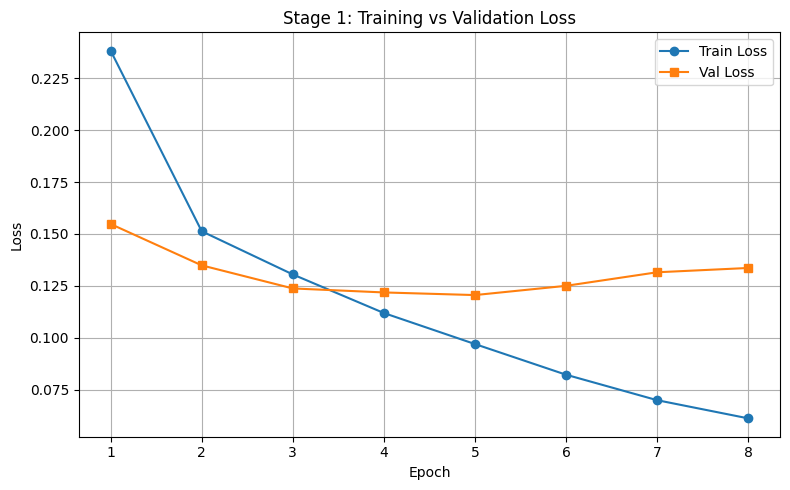

In [29]:
# Plot the loss curves
epochs = list(range(1, len(history["train_loss"]) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, history["train_loss"], label="Train Loss", marker='o')
plt.plot(epochs, history["val_loss"], label="Val Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 1: Training vs Validation Loss")
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
model.load_state_dict(torch.load("best_stage1.pt"))
model.eval()

C:\Users\chria\AppData\Local\Temp\ipykernel_17604\1686579958.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_stage1.pt"))


ClusterClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score

def predict_cluster_outputs(model, dataloader, threshold=0.3):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            all_preds.append(preds)
            all_labels.append(labels)

    return np.vstack(all_preds), np.vstack(all_labels)

In [32]:
y_pred, y_true = predict_cluster_outputs(model, val_cluster_loader)

f1 = f1_score(y_true, y_pred, average="micro")
precision = precision_score(y_true, y_pred, average="micro")
recall = recall_score(y_true, y_pred, average="micro")

print(f"F1 Score:      {f1:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")


F1 Score:      0.8504
Precision:     0.8191
Recall:        0.8842


In [33]:
cluster_dataframes = {}

for cluster_name in cluster_list:
    cluster_id = cluster2id[cluster_name]
    valid_tags = set(cluster_to_tags[cluster_name])

    filtered_rows = []

    for _, row in df.iterrows():
        tags = [row[col] for col in tag_columns if pd.notnull(row[col])]
        relevant_tags = [t for t in tags if t in valid_tags]
        if not relevant_tags:
            continue

        filtered_rows.append({
            "subject": row["subject"],
            "body": row["body"],
            "tags": relevant_tags  # Only tags from this cluster
        })

    cluster_df = pd.DataFrame(filtered_rows)
    cluster_dataframes[cluster_id] = cluster_df

    print(f"Cluster {cluster_id:2d} → {len(cluster_df)} samples | {len(valid_tags)} tags")

# Optional: preview first few rows of a cluster
cluster_dataframes[0].head()

Cluster  0 → 11939 samples | 26 tags
Cluster  1 → 62 samples | 15 tags
Cluster  2 → 93 samples | 10 tags
Cluster  3 → 5812 samples | 18 tags
Cluster  4 → 6187 samples | 46 tags
Cluster  5 → 46 samples | 15 tags
Cluster  6 → 1402 samples | 37 tags
Cluster  7 → 1952 samples | 49 tags
Cluster  8 → 510 samples | 20 tags
Cluster  9 → 372 samples | 19 tags
Cluster 10 → 280 samples | 19 tags
Cluster 11 → 138 samples | 15 tags
Cluster 12 → 10166 samples | 51 tags
Cluster 13 → 22 samples | 12 tags
Cluster 14 → 118 samples | 15 tags


,subject,body,tags
0,Query About Smart Home System Integration Feat...,"Dear Customer Support Team, I hope this messag...",[Product]
1,Question About Marketing Agency Software Compa...,"Dear Support Team, I hope this message reaches...","[Product, Feedback]"
2,Feature Query,"Dear Customer Support, I hope this message rea...",[Product]
3,Immediate Help Needed: Technical Problem with ...,"Dear Customer Support Team, I am submitting a ...","[Bug, Crash]"
4,Inquiry for Detailed Information on Agency Off...,"Dear Customer Support Team, I hope this messag...","[Product, Feedback]"


In [34]:
class TagDataset(Dataset):
    def __init__(self, encodings, tag_vectors):
        self.encodings = encodings
        self.tag_vectors = tag_vectors

    def __len__(self):
        return len(self.tag_vectors)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.tag_vectors[idx], dtype=torch.float32)
        }

cluster_datasets = {}

for cluster_id, df_cluster in cluster_dataframes.items():
    print(f"Processing Cluster {cluster_id:2d} ...")

    # tag vocabulary
    all_tags = sorted(set(tag for tags in df_cluster["tags"] for tag in tags))
    tag2id = {tag: i for i, tag in enumerate(all_tags)}
    id2tag = {i: tag for tag, i in tag2id.items()}
    vocab_size = len(tag2id)

    # tokenize text
    texts = (df_cluster["subject"] + " " + df_cluster["body"]).tolist()
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # multi-hot tag vectors
    tag_vectors = []
    for tags in df_cluster["tags"]:
        vec = np.zeros(vocab_size, dtype=np.float32)
        for tag in tags:
            if tag in tag2id:
                vec[tag2id[tag]] = 1.0
        tag_vectors.append(vec)

    dataset = TagDataset(encodings, tag_vectors)
    cluster_datasets[cluster_id] = {
        "dataset": dataset,
        "tag2id": tag2id,
        "id2tag": id2tag
    }

    print(f"Cluster {cluster_id:2d} → {len(dataset)} samples | {vocab_size} tag(s)")

Processing Cluster  0 ...
Cluster  0 → 11939 samples | 26 tag(s)
Processing Cluster  1 ...
Cluster  1 → 62 samples | 15 tag(s)
Processing Cluster  2 ...
Cluster  2 → 93 samples | 10 tag(s)
Processing Cluster  3 ...
Cluster  3 → 5812 samples | 18 tag(s)
Processing Cluster  4 ...
Cluster  4 → 6187 samples | 46 tag(s)
Processing Cluster  5 ...
Cluster  5 → 46 samples | 15 tag(s)
Processing Cluster  6 ...
Cluster  6 → 1402 samples | 37 tag(s)
Processing Cluster  7 ...
Cluster  7 → 1952 samples | 49 tag(s)
Processing Cluster  8 ...
Cluster  8 → 510 samples | 20 tag(s)
Processing Cluster  9 ...
Cluster  9 → 372 samples | 19 tag(s)
Processing Cluster 10 ...
Cluster 10 → 280 samples | 19 tag(s)
Processing Cluster 11 ...
Cluster 11 → 138 samples | 15 tag(s)
Processing Cluster 12 ...
Cluster 12 → 10166 samples | 51 tag(s)
Processing Cluster 13 ...
Cluster 13 → 22 samples | 12 tag(s)
Processing Cluster 14 ...
Cluster 14 → 118 samples | 15 tag(s)


In [35]:
class TagClassifier(nn.Module):
    def __init__(self, hidden_size, num_labels):
        super(TagClassifier, self).__init__()
        self.model = AutoModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # shape: (batch_size, hidden_dim)
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [46]:
def compute_pos_weights(labels_tensor):
    # labels_tensor shape: (num_samples, num_tags)
    total_samples = labels_tensor.shape[0]
    pos_counts = labels_tensor.sum(dim=0)
    neg_counts = total_samples - pos_counts
    weights = neg_counts / (pos_counts + 1e-5)  # avoid division by zero
    return weights

In [47]:
def train_tag_model(dataset, cluster_id, tag2id, epochs=10, batch_size=16, hidden_size=256, device="cuda"):
    train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)

    train_subset = torch.utils.data.Subset(dataset, train_indices)
    val_subset = torch.utils.data.Subset(dataset, val_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    model = TagClassifier(hidden_size=hidden_size, num_labels=len(tag2id)).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    train_labels = torch.stack([dataset[i]["labels"] for i in train_indices])
    pos_weights = compute_pos_weights(train_labels)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Cluster {cluster_id} - Epoch {epoch+1} - Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"cluster_{cluster_id}_model.pt")
            print("Saved best model.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    return model


In [48]:
tag_models = {}

for cluster_id in range(len(cluster_datasets)):
    data_info = cluster_datasets[cluster_id]
    dataset = data_info["dataset"]
    tag2id = data_info["tag2id"]

    print(f"\nTraining model for Cluster {cluster_id}")
    model = train_tag_model(dataset, cluster_id, tag2id)
    tag_models[cluster_id] = model


Training model for Cluster 0


Cluster 0 - Epoch 1 - Training:   0%|          | 0/672 [00:00<?, ?it/s]c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Cluster 0 - Epoch 1 - Training: 100%|██████████| 672/672 [00:49<00:00, 13.63it/s]


Epoch 1 - Train Loss: 1.4242 - Val Loss: 48408.3211
Saved best model.


Cluster 0 - Epoch 2 - Training: 100%|██████████| 672/672 [00:49<00:00, 13.58it/s]


Epoch 2 - Train Loss: 1.4020 - Val Loss: 54254.8365


Cluster 0 - Epoch 3 - Training: 100%|██████████| 672/672 [00:50<00:00, 13.30it/s]


Epoch 3 - Train Loss: 1.4404 - Val Loss: 54118.5189


Cluster 0 - Epoch 4 - Training: 100%|██████████| 672/672 [00:50<00:00, 13.24it/s]


Epoch 4 - Train Loss: 1.3355 - Val Loss: 55526.8069
Early stopping.

Training model for Cluster 1


Cluster 1 - Epoch 1 - Training: 100%|██████████| 4/4 [00:00<00:00, 19.99it/s]


Epoch 1 - Train Loss: 1.2225 - Val Loss: 49747.6367
Saved best model.


Cluster 1 - Epoch 2 - Training: 100%|██████████| 4/4 [00:00<00:00, 19.99it/s]


Epoch 2 - Train Loss: 1.2265 - Val Loss: 51274.6680


Cluster 1 - Epoch 3 - Training: 100%|██████████| 4/4 [00:00<00:00, 20.09it/s]


Epoch 3 - Train Loss: 1.2893 - Val Loss: 52120.4180


Cluster 1 - Epoch 4 - Training: 100%|██████████| 4/4 [00:00<00:00, 20.15it/s]


Epoch 4 - Train Loss: 1.1919 - Val Loss: 53381.6836
Early stopping.

Training model for Cluster 2


Cluster 2 - Epoch 1 - Training: 100%|██████████| 6/6 [00:00<00:00, 20.73it/s]


Epoch 1 - Train Loss: 1.1618 - Val Loss: 62172.7930
Saved best model.


Cluster 2 - Epoch 2 - Training: 100%|██████████| 6/6 [00:00<00:00, 21.44it/s]


Epoch 2 - Train Loss: 1.1894 - Val Loss: 67121.4922


Cluster 2 - Epoch 3 - Training: 100%|██████████| 6/6 [00:00<00:00, 20.84it/s]


Epoch 3 - Train Loss: 1.1021 - Val Loss: 68571.3828


Cluster 2 - Epoch 4 - Training: 100%|██████████| 6/6 [00:00<00:00, 21.27it/s]


Epoch 4 - Train Loss: 1.1267 - Val Loss: 66147.0000
Early stopping.

Training model for Cluster 3


Cluster 3 - Epoch 1 - Training: 100%|██████████| 327/327 [00:24<00:00, 13.37it/s]


Epoch 1 - Train Loss: 1.2339 - Val Loss: 117030.1055
Saved best model.


Cluster 3 - Epoch 2 - Training: 100%|██████████| 327/327 [00:24<00:00, 13.36it/s]


Epoch 2 - Train Loss: 1.2702 - Val Loss: 130367.0631


Cluster 3 - Epoch 3 - Training: 100%|██████████| 327/327 [00:24<00:00, 13.57it/s]


Epoch 3 - Train Loss: 1.2595 - Val Loss: 156215.1203


Cluster 3 - Epoch 4 - Training: 100%|██████████| 327/327 [00:25<00:00, 13.03it/s]


Epoch 4 - Train Loss: 1.2257 - Val Loss: 194866.8706
Early stopping.

Training model for Cluster 4


Cluster 4 - Epoch 1 - Training: 100%|██████████| 348/348 [00:25<00:00, 13.63it/s]


Epoch 1 - Train Loss: 1.3795 - Val Loss: 18302.0966
Saved best model.


Cluster 4 - Epoch 2 - Training: 100%|██████████| 348/348 [00:25<00:00, 13.59it/s]


Epoch 2 - Train Loss: 1.4068 - Val Loss: 20598.3356


Cluster 4 - Epoch 3 - Training: 100%|██████████| 348/348 [00:27<00:00, 12.80it/s]


Epoch 3 - Train Loss: 1.3853 - Val Loss: 21663.0295


Cluster 4 - Epoch 4 - Training: 100%|██████████| 348/348 [00:27<00:00, 12.82it/s]


Epoch 4 - Train Loss: 1.4181 - Val Loss: 28303.8516
Early stopping.

Training model for Cluster 5


Cluster 5 - Epoch 1 - Training: 100%|██████████| 3/3 [00:00<00:00, 18.46it/s]


Epoch 1 - Train Loss: 1.3235 - Val Loss: 1.2279
Saved best model.


Cluster 5 - Epoch 2 - Training: 100%|██████████| 3/3 [00:00<00:00, 18.69it/s]


Epoch 2 - Train Loss: 1.2748 - Val Loss: 1.2340


Cluster 5 - Epoch 3 - Training: 100%|██████████| 3/3 [00:00<00:00, 18.60it/s]

Epoch 3 - Train Loss: 1.3462 - Val Loss: 1.2172


Saved best model.


Cluster 5 - Epoch 4 - Training: 100%|██████████| 3/3 [00:00<00:00, 18.60it/s]


Epoch 4 - Train Loss: 1.4161 - Val Loss: 1.2175


Cluster 5 - Epoch 5 - Training: 100%|██████████| 3/3 [00:00<00:00, 18.97it/s]

Epoch 5 - Train Loss: 1.2739 - Val Loss: 1.2224

Cluster 5 - Epoch 6 - Training: 100%|██████████| 3/3 [00:00<00:00, 18.46it/s]


Epoch 6 - Train Loss: 1.2636 - Val Loss: 1.2224
Early stopping.

Training model for Cluster 6


Cluster 6 - Epoch 1 - Training: 100%|██████████| 79/79 [00:05<00:00, 13.28it/s]


Epoch 1 - Train Loss: 1.3356 - Val Loss: 1.4860
Saved best model.


Cluster 6 - Epoch 2 - Training: 100%|██████████| 79/79 [00:05<00:00, 13.22it/s]


Epoch 2 - Train Loss: 1.3192 - Val Loss: 1.5280


Cluster 6 - Epoch 3 - Training: 100%|██████████| 79/79 [00:05<00:00, 13.24it/s]


Epoch 3 - Train Loss: 1.3163 - Val Loss: 1.5156


Cluster 6 - Epoch 4 - Training: 100%|██████████| 79/79 [00:05<00:00, 13.26it/s]


Epoch 4 - Train Loss: 1.3075 - Val Loss: 1.4982
Early stopping.

Training model for Cluster 7


Cluster 7 - Epoch 1 - Training: 100%|██████████| 110/110 [00:07<00:00, 13.79it/s]


Epoch 1 - Train Loss: 1.3825 - Val Loss: 1.6587
Saved best model.


Cluster 7 - Epoch 2 - Training: 100%|██████████| 110/110 [00:07<00:00, 13.78it/s]


Epoch 2 - Train Loss: 1.3524 - Val Loss: 1.6263
Saved best model.


Cluster 7 - Epoch 3 - Training: 100%|██████████| 110/110 [00:07<00:00, 13.75it/s]


Epoch 3 - Train Loss: 1.3959 - Val Loss: 1.6443


Cluster 7 - Epoch 4 - Training: 100%|██████████| 110/110 [00:07<00:00, 14.62it/s]


Epoch 4 - Train Loss: 1.3650 - Val Loss: 1.5868
Saved best model.


Cluster 7 - Epoch 5 - Training: 100%|██████████| 110/110 [00:07<00:00, 14.73it/s]


Epoch 5 - Train Loss: 1.3702 - Val Loss: 1.6237


Cluster 7 - Epoch 6 - Training: 100%|██████████| 110/110 [00:07<00:00, 14.75it/s]


Epoch 6 - Train Loss: 1.3738 - Val Loss: 1.6251


Cluster 7 - Epoch 7 - Training: 100%|██████████| 110/110 [00:07<00:00, 14.71it/s]


Epoch 7 - Train Loss: 1.3778 - Val Loss: 1.6642
Early stopping.

Training model for Cluster 8


Cluster 8 - Epoch 1 - Training: 100%|██████████| 29/29 [00:01<00:00, 15.89it/s]


Epoch 1 - Train Loss: 1.3314 - Val Loss: 25833.4138
Saved best model.


Cluster 8 - Epoch 2 - Training: 100%|██████████| 29/29 [00:01<00:00, 15.85it/s]


Epoch 2 - Train Loss: 1.3203 - Val Loss: 28024.4708


Cluster 8 - Epoch 3 - Training: 100%|██████████| 29/29 [00:01<00:00, 15.89it/s]


Epoch 3 - Train Loss: 1.2834 - Val Loss: 29469.6281


Cluster 8 - Epoch 4 - Training: 100%|██████████| 29/29 [00:01<00:00, 15.84it/s]


Epoch 4 - Train Loss: 1.2952 - Val Loss: 28175.1663
Early stopping.

Training model for Cluster 9


Cluster 9 - Epoch 1 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.35it/s]


Epoch 1 - Train Loss: 1.2864 - Val Loss: 1.1365
Saved best model.


Cluster 9 - Epoch 2 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.50it/s]


Epoch 2 - Train Loss: 1.3005 - Val Loss: 1.1340
Saved best model.


Cluster 9 - Epoch 3 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.47it/s]


Epoch 3 - Train Loss: 1.3253 - Val Loss: 1.1347


Cluster 9 - Epoch 4 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.45it/s]


Epoch 4 - Train Loss: 1.3093 - Val Loss: 1.1295
Saved best model.


Cluster 9 - Epoch 5 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.44it/s]


Epoch 5 - Train Loss: 1.3013 - Val Loss: 1.1283
Saved best model.


Cluster 9 - Epoch 6 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.36it/s]


Epoch 6 - Train Loss: 1.3195 - Val Loss: 1.1193
Saved best model.


Cluster 9 - Epoch 7 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.36it/s]


Epoch 7 - Train Loss: 1.3009 - Val Loss: 1.1167
Saved best model.


Cluster 9 - Epoch 8 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.44it/s]


Epoch 8 - Train Loss: 1.3118 - Val Loss: 1.1134
Saved best model.


Cluster 9 - Epoch 9 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.36it/s]


Epoch 9 - Train Loss: 1.2971 - Val Loss: 1.1030
Saved best model.


Cluster 9 - Epoch 10 - Training: 100%|██████████| 21/21 [00:01<00:00, 17.42it/s]


Epoch 10 - Train Loss: 1.2663 - Val Loss: 1.1196

Training model for Cluster 10


Cluster 10 - Epoch 1 - Training: 100%|██████████| 16/16 [00:00<00:00, 17.52it/s]


Epoch 1 - Train Loss: 1.3538 - Val Loss: 0.8188
Saved best model.


Cluster 10 - Epoch 2 - Training: 100%|██████████| 16/16 [00:00<00:00, 17.35it/s]


Epoch 2 - Train Loss: 1.3532 - Val Loss: 0.8277


Cluster 10 - Epoch 3 - Training: 100%|██████████| 16/16 [00:00<00:00, 17.58it/s]


Epoch 3 - Train Loss: 1.3132 - Val Loss: 0.8375


Cluster 10 - Epoch 4 - Training: 100%|██████████| 16/16 [00:00<00:00, 17.56it/s]


Epoch 4 - Train Loss: 1.2934 - Val Loss: 0.8370
Early stopping.

Training model for Cluster 11


Cluster 11 - Epoch 1 - Training: 100%|██████████| 8/8 [00:00<00:00, 17.70it/s]


Epoch 1 - Train Loss: 1.3060 - Val Loss: 1.2555
Saved best model.


Cluster 11 - Epoch 2 - Training: 100%|██████████| 8/8 [00:00<00:00, 17.57it/s]


Epoch 2 - Train Loss: 1.2796 - Val Loss: 1.2626


Cluster 11 - Epoch 3 - Training: 100%|██████████| 8/8 [00:00<00:00, 17.40it/s]


Epoch 3 - Train Loss: 1.2795 - Val Loss: 1.2448
Saved best model.


Cluster 11 - Epoch 4 - Training: 100%|██████████| 8/8 [00:00<00:00, 17.58it/s]


Epoch 4 - Train Loss: 1.3147 - Val Loss: 1.2580


Cluster 11 - Epoch 5 - Training: 100%|██████████| 8/8 [00:00<00:00, 17.82it/s]


Epoch 5 - Train Loss: 1.2944 - Val Loss: 1.2483


Cluster 11 - Epoch 6 - Training: 100%|██████████| 8/8 [00:00<00:00, 17.65it/s]


Epoch 6 - Train Loss: 1.2962 - Val Loss: 1.2460
Early stopping.

Training model for Cluster 12


Cluster 12 - Epoch 1 - Training: 100%|██████████| 572/572 [00:41<00:00, 13.66it/s]


Epoch 1 - Train Loss: 1.3492 - Val Loss: 66790.0667
Saved best model.


Cluster 12 - Epoch 2 - Training: 100%|██████████| 572/572 [00:41<00:00, 13.66it/s]


Epoch 2 - Train Loss: 1.3587 - Val Loss: 83801.0320


Cluster 12 - Epoch 3 - Training: 100%|██████████| 572/572 [00:41<00:00, 13.67it/s]


Epoch 3 - Train Loss: 1.3308 - Val Loss: 93606.1854


Cluster 12 - Epoch 4 - Training: 100%|██████████| 572/572 [00:42<00:00, 13.46it/s]


Epoch 4 - Train Loss: 1.3025 - Val Loss: 102486.7100
Early stopping.

Training model for Cluster 13


Cluster 13 - Epoch 1 - Training: 100%|██████████| 2/2 [00:00<00:00, 24.56it/s]


Epoch 1 - Train Loss: 1.1075 - Val Loss: 0.7093
Saved best model.


Cluster 13 - Epoch 2 - Training: 100%|██████████| 2/2 [00:00<00:00, 25.20it/s]

Epoch 2 - Train Loss: 1.0840 - Val Loss: 0.7042


Saved best model.


Cluster 13 - Epoch 3 - Training: 100%|██████████| 2/2 [00:00<00:00, 25.23it/s]


Epoch 3 - Train Loss: 1.3513 - Val Loss: 0.7045


Cluster 13 - Epoch 4 - Training: 100%|██████████| 2/2 [00:00<00:00, 25.43it/s]


Epoch 4 - Train Loss: 1.2441 - Val Loss: 0.7075


Cluster 13 - Epoch 5 - Training: 100%|██████████| 2/2 [00:00<00:00, 24.28it/s]


Epoch 5 - Train Loss: 1.1059 - Val Loss: 0.7040
Saved best model.


Cluster 13 - Epoch 6 - Training: 100%|██████████| 2/2 [00:00<00:00, 24.84it/s]

Epoch 6 - Train Loss: 1.1384 - Val Loss: 0.6961


Saved best model.


Cluster 13 - Epoch 7 - Training: 100%|██████████| 2/2 [00:00<00:00, 25.52it/s]

Epoch 7 - Train Loss: 1.1359 - Val Loss: 0.6926


Saved best model.


Cluster 13 - Epoch 8 - Training: 100%|██████████| 2/2 [00:00<00:00, 24.85it/s]

Epoch 8 - Train Loss: 1.0720 - Val Loss: 0.6911


Saved best model.


Cluster 13 - Epoch 9 - Training: 100%|██████████| 2/2 [00:00<00:00, 25.46it/s]

Epoch 9 - Train Loss: 1.2030 - Val Loss: 0.6898


Saved best model.


Cluster 13 - Epoch 10 - Training: 100%|██████████| 2/2 [00:00<00:00, 25.04it/s]

Epoch 10 - Train Loss: 1.1814 - Val Loss: 0.7015

Training model for Cluster 14



Cluster 14 - Epoch 1 - Training: 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


Epoch 1 - Train Loss: 1.3029 - Val Loss: 0.7641
Saved best model.


Cluster 14 - Epoch 2 - Training: 100%|██████████| 7/7 [00:00<00:00, 14.61it/s]


Epoch 2 - Train Loss: 1.2742 - Val Loss: 0.7673


Cluster 14 - Epoch 3 - Training: 100%|██████████| 7/7 [00:00<00:00, 14.72it/s]


Epoch 3 - Train Loss: 1.3830 - Val Loss: 0.7846


Cluster 14 - Epoch 4 - Training: 100%|██████████| 7/7 [00:00<00:00, 14.73it/s]

Epoch 4 - Train Loss: 1.2960 - Val Loss: 0.8020
Early stopping.


In [49]:
# Evaluation of Tags Models
tag_models = {}

for cluster_id in range(len(cluster_datasets)):
    data_info = cluster_datasets[cluster_id]
    tag2id = data_info["tag2id"]

    model = TagClassifier(hidden_size=256, num_labels=len(tag2id))
    model.load_state_dict(torch.load(f"cluster_{cluster_id}_model.pt"))
    model.to(device)
    model.eval()

    tag_models[cluster_id] = model


C:\Users\chria\AppData\Local\Temp\ipykernel_17604\2803351376.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"cluster_{cluster_id}_mode

In [53]:
def evaluate_tag_model(model, dataset, cluster_id, tag2id, batch_size=16):
    _, val_indices = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
    val_subset = Subset(dataset, val_indices)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    all_preds, all_labels = [], []

    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= 0.5).astype(int)

            all_preds.extend(preds)
            all_labels.extend(labels)

    precision = precision_score(all_labels, all_preds, average="micro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="micro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="micro", zero_division=0)

    print(f"Cluster {cluster_id} — F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    return f1, precision, recall

In [54]:

for cluster_id in range(len(cluster_datasets)):
    dataset = cluster_datasets[cluster_id]["dataset"]
    tag2id = cluster_datasets[cluster_id]["tag2id"]
    model = tag_models[cluster_id]
    evaluate_tag_model(model, dataset, cluster_id, tag2id)

c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Cluster 0 — F1: 0.2064, Precision: 0.1227, Recall: 0.6494
Cluster 1 — F1: 0.1429, Precision: 0.0794, Recall: 0.7143
Cluster 2 — F1: 0.1224, Precision: 0.0769, Recall: 0.3000


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Cluster 3 — F1: 0.4297, Precision: 0.2770, Recall: 0.9572


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Cluster 4 — F1: 0.0828, Precision: 0.0473, Recall: 0.3333
Cluster 5 — F1: 0.1951, Precision: 0.1111, Recall: 0.8000
Cluster 6 — F1: 0.1188, Precision: 0.0658, Recall: 0.6064


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Cluster 7 — F1: 0.1103, Precision: 0.0606, Recall: 0.6120
Cluster 8 — F1: 0.0828, Precision: 0.0467, Recall: 0.3654
Cluster 9 — F1: 0.1481, Precision: 0.0827, Recall: 0.7111
Cluster 10 — F1: 0.2544, Precision: 0.1480, Recall: 0.9062
Cluster 11 — F1: 0.2692, Precision: 0.1556, Recall: 1.0000


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is depre

Cluster 12 — F1: 0.1750, Precision: 0.0994, Recall: 0.7298
Cluster 13 — F1: 0.3000, Precision: 0.1765, Recall: 1.0000
Cluster 14 — F1: 0.1412, Precision: 0.0822, Recall: 0.5000


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# Distribution of Tags in Clusters
for cid, cluster in cluster_datasets.items():
    tag2id = cluster["tag2id"]
    id2tag = cluster["id2tag"]
    dataset = cluster["dataset"]

    counts = Counter()

    for i in range(len(dataset)):
        item = dataset[i]
        labels = item["labels"]
        indices = torch.where(labels == 1.0)[0]
        for idx in indices:
            tag = id2tag[idx.item()]
            counts[tag] += 1

    print(f"Cluster {cid} — Total Samples: {len(dataset)}")
    for tag, count in counts.most_common(5):
        print(f"   {tag}: {count}")
    print()



📊 Cluster 0 — Total Samples: 11939
   IT: 5153
   Feedback: 3903
   Bug: 3649
   Product: 1100
   Crash: 671

📊 Cluster 1 — Total Samples: 62
   Software Update: 30
   Update: 7
   Cache: 6
   Upgrade: 4
   Outdated Software: 3

📊 Cluster 2 — Total Samples: 93
   Brand Development: 24
   Branding: 16
   Brand: 14
   Brand Expansion: 13
   Brand Growth: 13

📊 Cluster 3 — Total Samples: 5812
   Security: 3674
   Disruption: 2430
   Virus: 370
   Alert: 186
   Vulnerability: 56

📊 Cluster 4 — Total Samples: 6187
   Outage: 2222
   Network: 2003
   Tech Support: 1707
   Hardware: 660
   Maintenance: 195

📊 Cluster 5 — Total Samples: 46
   API: 26
   Usability: 4
   Tutorial: 3
   UI/UX: 3
   Dashboard: 2

📊 Cluster 6 — Total Samples: 1402
   Billing: 908
   Payment: 742
   Account: 294
   Refund: 215
   Login: 144

📊 Cluster 7 — Total Samples: 1952
   Sales: 1286
   Marketing: 574
   Lead: 251
   Strategy: 187
   Campaign: 112

📊 Cluster 8 — Total Samples: 510
   Software: 257
   Integrati

In [ ]:
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

# Step 1: Tokenize and prepare test dataset
test_texts = (test_df["subject"] + " " + test_df["body"]).tolist()
test_enc = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
test_dataset = TagDataset(test_enc, test_df["tag_vector"].tolist())
test_loader = DataLoader(test_dataset, batch_size=16)

# Step 2: Load cluster model
n_clusters = len(cluster2id)
cluster_model = ClusterClassifier(num_clusters=n_clusters)
cluster_model.load_state_dict(torch.load("best_stage1.pt"))
cluster_model.to(device)
cluster_model.eval()

# Step 3: Predict cluster labels
def predict_clusters(input_ids, attention_mask, model, threshold=0.5):
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()  # shape: [batch_size, num_clusters]
    return preds

# Step 4: Predict tags for each predicted cluster
def predict_tags_for_clusters(cluster_preds, input_ids, attention_mask, tag_models, cluster_datasets, threshold=0.5):
    final_tag_preds = []

    for b in range(cluster_preds.size(0)):
        tag_output = []

        for cluster_id in range(cluster_preds.size(1)):
            if cluster_preds[b, cluster_id] == 1:
                tag_model = tag_models.get(cluster_id)
                if tag_model:
                    tag2id = cluster_datasets[cluster_id]["tag2id"]
                    num_labels = len(tag2id)

                    with torch.no_grad():
                        logits = tag_model(input_ids[b].unsqueeze(0), attention_mask[b].unsqueeze(0))
                        probs = torch.sigmoid(logits).squeeze(0)
                        preds = (probs > threshold).float().cpu().numpy()

                    tag_output.append((cluster_id, preds, tag2id))

        final_tag_preds.append(tag_output)

    return final_tag_preds

# Step 5: Full pipeline evaluation
def evaluate_full_pipeline(test_dataset, cluster_model, tag_models, cluster_datasets, threshold=0.5):
    all_preds = []
    all_labels = []

    cluster_model.eval()

    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        true_labels = batch["labels"].cpu().numpy()

        cluster_preds = predict_clusters(input_ids, attention_mask, cluster_model, threshold)
        tag_preds = predict_tags_for_clusters(cluster_preds, input_ids, attention_mask, tag_models, cluster_datasets, threshold)

        for true, tag_pred in zip(true_labels, tag_preds):
            pred_vec = np.zeros_like(true)

            for cluster_id, preds, tag2id in tag_pred:
                for tag_idx, val in enumerate(preds):
                    if val == 1.0:
                        pred_vec[tag_idx] = 1

            all_preds.append(pred_vec)
            all_labels.append(true)

    precision = precision_score(all_labels, all_preds, average="micro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="micro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="micro", zero_division=0)

    print("\n✅ Final Test Evaluation:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

evaluate_full_pipeline(
    test_dataset=test_dataset,
    cluster_model=cluster_model,
    tag_models=tag_models,
    cluster_datasets=cluster_datasets,
    threshold=0.5
)

C:\Users\chria\AppData\Local\Temp\ipykernel_17604\3066827398.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cluster_model.load_state_dict(torch.load("best_stage1.pt"))


✅ Final Test Evaluation:
Precision: 0.0549
Recall:    0.3086
F1 Score:  0.0932


In [ ]:
def evaluate_stage2_per_cluster(test_loader, cluster_model, tag_models, cluster_datasets, threshold=0.5):
    cluster_model.eval()
    cluster_metrics = {}

    for cluster_id, tag_model in tag_models.items():
        tag_model.eval()
        tag2id = cluster_datasets[cluster_id]["tag2id"]
        num_tags = len(tag2id)

        y_true = []
        y_pred = []

        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].cpu().numpy()

            with torch.no_grad():
                cluster_logits = cluster_model(input_ids=input_ids, attention_mask=attention_mask)
                cluster_probs = torch.sigmoid(cluster_logits).cpu().numpy()
                predicted_clusters = (cluster_probs >= threshold).astype(int)

                for i in range(len(predicted_clusters)):
                    if predicted_clusters[i][cluster_id] != 1:
                        continue  # skip if this sample doesn't belong to cluster

                    input_id = input_ids[i].unsqueeze(0)
                    attention = attention_mask[i].unsqueeze(0)
                    tag_logits = tag_model(input_id, attention)
                    tag_probs = torch.sigmoid(tag_logits).cpu().numpy()[0]
                    pred = (tag_probs >= threshold).astype(int)

                    y_true.append(labels[i][:num_tags])
                    y_pred.append(pred)

        if y_true:
            precision = precision_score(y_true, y_pred, average="micro", zero_division=0)
            recall = recall_score(y_true, y_pred, average="micro", zero_division=0)
            f1 = f1_score(y_true, y_pred, average="micro", zero_division=0)
            cluster_metrics[cluster_id] = (f1, precision, recall)
            print(f"📦 Cluster {cluster_id} — F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        else:
            print(f"📦 Cluster {cluster_id} — no matching predictions in test set")

    return cluster_metrics

evaluate_stage2_per_cluster(
    test_loader=test_loader,
    cluster_model=cluster_model,
    tag_models=tag_models,
    cluster_datasets=cluster_datasets,
    threshold=0.5
)


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 0 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 1 — no matching predictions in test set
📦 Cluster 2 — no matching predictions in test set


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 3 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 4 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 5 — no matching predictions in test set


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 6 — F1: 0.1393, Precision: 0.0751, Recall: 0.9615
📦 Cluster 7 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 8 — no matching predictions in test set


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 9 — no matching predictions in test set
📦 Cluster 10 — no matching predictions in test set
📦 Cluster 11 — no matching predictions in test set
📦 Cluster 12 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 13 — no matching predictions in test set
📦 Cluster 14 — no matching predictions in test set


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{0: (0.0, 0.0, 0.0),
 3: (0.0, 0.0, 0.0),
 4: (0.0, 0.0, 0.0),
 6: (0.1392757660167131, 0.07507507507507508, 0.9615384615384616),
 7: (0.0, 0.0, 0.0),
 12: (0.0, 0.0, 0.0)}

In [113]:
def analyze_cluster_distribution(test_loader, cluster_model, threshold=0.5):
    cluster_model.eval()
    cluster_counts = Counter()

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            cluster_logits = cluster_model(input_ids=input_ids, attention_mask=attention_mask)
            cluster_probs = torch.sigmoid(cluster_logits).cpu().numpy()
            predicted_clusters = (cluster_probs > threshold).astype(int)

            for row in predicted_clusters:
                cluster_ids = np.where(row == 1)[0]
                cluster_counts.update(cluster_ids)

    print("\n📊 Cluster distribution in test set:")
    for cluster_id in range(max(cluster_counts.keys()) + 1):
        print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} samples")

analyze_cluster_distribution(test_loader, cluster_model, threshold=0.5)



📊 Cluster distribution in test set:
Cluster 0: 13 samples
Cluster 1: 0 samples
Cluster 2: 0 samples
Cluster 3: 2 samples
Cluster 4: 5 samples
Cluster 5: 0 samples
Cluster 6: 36 samples
Cluster 7: 4 samples
Cluster 8: 0 samples
Cluster 9: 0 samples
Cluster 10: 0 samples
Cluster 11: 0 samples
Cluster 12: 11 samples


In [118]:
def evaluate_multicluster_pipeline(test_loader, cluster_model, tag_models, cluster_datasets, global_tag2id, threshold=0.5):
    all_preds  = []
    all_labels = []

    cluster_model.eval()
    for batch in test_loader:
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        true_vectors   = batch["labels"].cpu().numpy()  # shape [B, total_tags]

        # predict clusters (multi-label sigmoid)
        with torch.no_grad():
            logits        = cluster_model(input_ids=input_ids, attention_mask=attention_mask)
            cluster_probs = torch.sigmoid(logits)
            cluster_preds = (cluster_probs >= threshold).float()  # [B, n_clusters]

        # for each example in batch
        for i in range(true_vectors.shape[0]):
            pred_vector = np.zeros_like(true_vectors[i])

            # run each active cluster’s tag model
            for cluster_id in range(cluster_preds.size(1)):
                if cluster_preds[i, cluster_id] != 1:
                    continue
                tag_model = tag_models.get(cluster_id)
                if tag_model is None:
                    continue

                local_id2tag = cluster_datasets[cluster_id]["id2tag"]
                with torch.no_grad():
                    out        = tag_model(
                                   input_ids[i].unsqueeze(0),
                                   attention_mask[i].unsqueeze(0)
                                )
                    tag_probs  = torch.sigmoid(out).cpu().numpy()[0]
                    local_preds = (tag_probs >= threshold).astype(int)

                # map local → global indices
                for local_idx, on in enumerate(local_preds):
                    if on:
                        tag_name   = local_id2tag[local_idx]
                        global_idx = global_tag2id[tag_name]
                        pred_vector[global_idx] = 1

            all_preds.append(pred_vector)
            all_labels.append(true_vectors[i])

    # compute micro-averaged metrics
    precision = precision_score(all_labels, all_preds, average="micro", zero_division=0)
    recall    = recall_score(all_labels, all_preds, average="micro", zero_division=0)
    f1        = f1_score(all_labels, all_preds, average="micro", zero_division=0)

    print("\n✅ Fixed Multi-Cluster Test Evaluation:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

In [119]:
evaluate_multicluster_pipeline(
    test_loader=test_loader,
    cluster_model=cluster_model,
    tag_models=tag_models,
    cluster_datasets=cluster_datasets,
    global_tag2id=global_tag2id,
    threshold=0.5
)


✅ Fixed Multi-Cluster Test Evaluation:
Precision: 0.0987
Recall:    0.5802
F1 Score:  0.1688


In [122]:
evaluate_stage2_per_cluster(
    test_loader=test_loader,
    cluster_model=cluster_model,
    tag_models=tag_models,
    cluster_datasets=cluster_datasets,
    threshold=0.5  # from your threshold sweep
)

c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 0 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 1 — no matching predictions in test set
📦 Cluster 2 — no matching predictions in test set
📦 Cluster 3 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 4 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 5 — no matching predictions in test set


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 6 — F1: 0.1393, Precision: 0.0751, Recall: 0.9615
📦 Cluster 7 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 8 — no matching predictions in test set
📦 Cluster 9 — no matching predictions in test set


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📦 Cluster 10 — no matching predictions in test set
📦 Cluster 11 — no matching predictions in test set
📦 Cluster 12 — F1: 0.0000, Precision: 0.0000, Recall: 0.0000
📦 Cluster 13 — no matching predictions in test set
📦 Cluster 14 — no matching predictions in test set


c:\Users\chria\Documents\Deep Learning\tickets-project\.venv\Lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{0: (0.0, 0.0, 0.0),
 3: (0.0, 0.0, 0.0),
 4: (0.0, 0.0, 0.0),
 6: (0.1392757660167131, 0.07507507507507508, 0.9615384615384616),
 7: (0.0, 0.0, 0.0),
 12: (0.0, 0.0, 0.0)}

In [ ]:
a